In [1]:
# %load_ext autoreload
# %autoreload

In [2]:
import os, glob, jax

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from tqdm import tqdm

jax.devices("gpu")

[cuda(id=0)]

## Fitting kernel at 64**3 particles resolution

In [3]:
import jax_cosmo as jc

mesh_shape= [64, 64, 64]
box_size  = [25., 25., 25.]
particles_per_dim = 256
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.6711, sigma8=0.8)

# SIM = "/cluster/scratch/athomsen/flatiron/CAMELS/Sims/IllustrisTNG_DM/CV/CV_0"
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG_DM/CV/CV_0"

In [4]:
import camels_library as cl
import readgadget

INITIAL = os.path.join(SIM, "ICs/ics")

header   = readgadget.header(INITIAL)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(INITIAL, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(INITIAL, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(INITIAL, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)

# subsample to reduce the number of particles 
pos_i = (pos_i/BoxSize*64).reshape([particles_per_dim, particles_per_dim, particles_per_dim,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([particles_per_dim, particles_per_dim, particles_per_dim, 3])[::4,::4,::4,:].reshape([-1,3])

a_i   = 1./(1+redshift)

In [5]:
scales = []
poss = []
vels = []

SNAPSHOTS = glob.glob(os.path.join(SIM, "snapshot_???.hdf5"))
SNAPSHOTS.sort()

# Loading all the intermediate snapshots
for i, SNAPSHOT in tqdm(enumerate(SNAPSHOTS), total=len(SNAPSHOTS)):    
    header   = readgadget.header(SNAPSHOT)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(SNAPSHOT, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(SNAPSHOT, "POS ", ptype)[ids]/1e3        #positions in Mpc/h
    vel = readgadget.read_block(SNAPSHOT, "VEL ", ptype)[ids]            #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [02:01<00:00,  3.57s/it]


In [6]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, invlaplace_kernel, longrange_kernel
from jaxpm.nn import NeuralSplineFourierFilter
from jaxpm.utils import power_spectrum

rng_seq = hk.PRNGSequence(1)

2024-11-11 16:01:52.403254: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


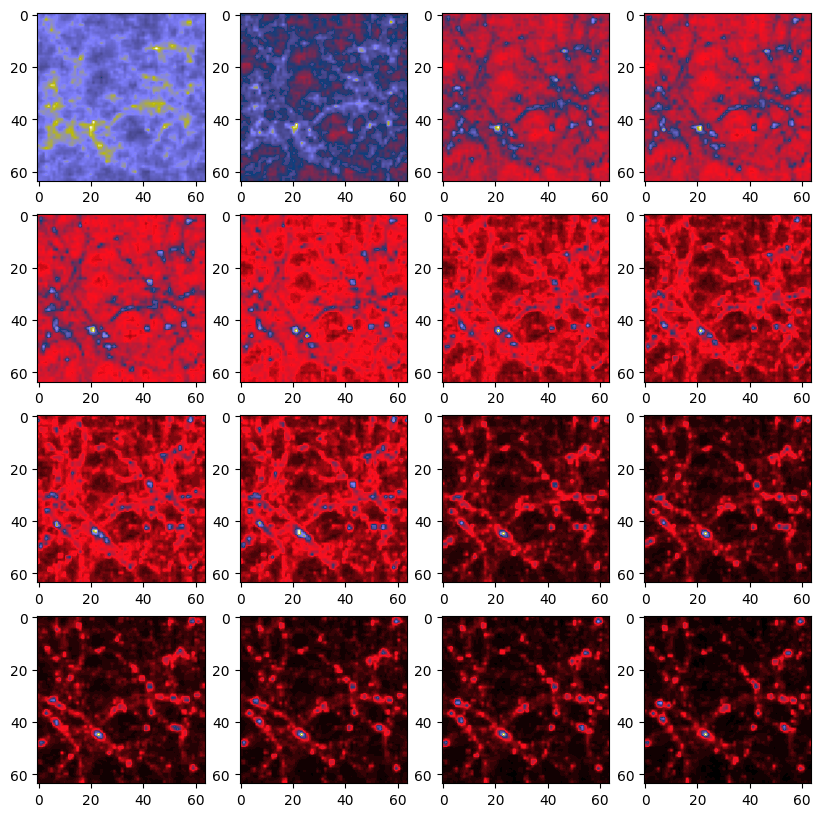

In [7]:
# High res simulation
plt.figure(figsize=[10,10])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

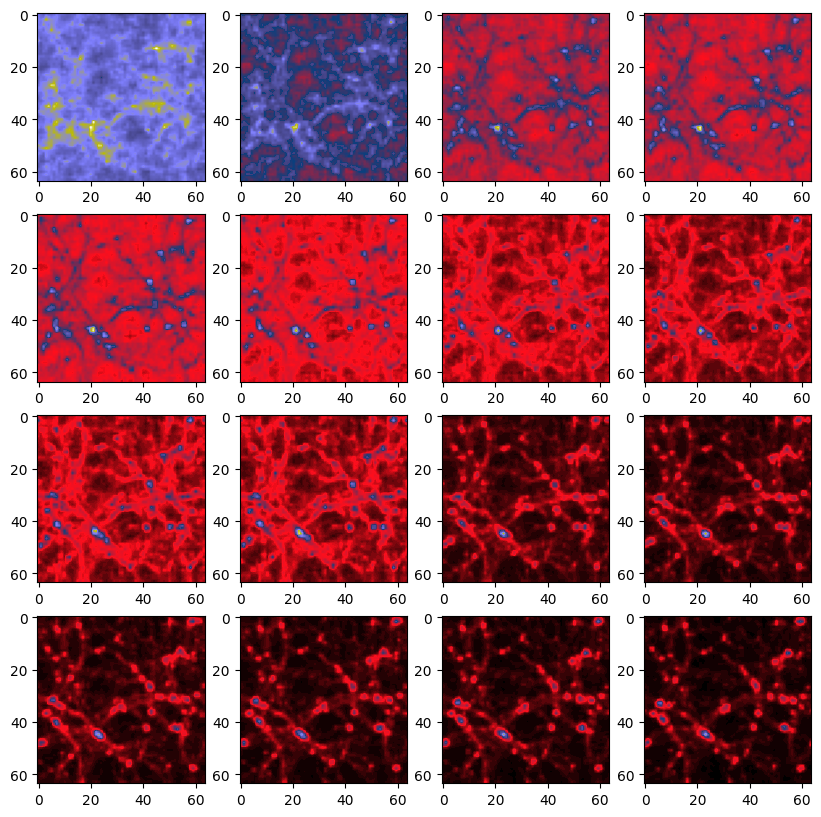

In [8]:
# Run the reference simulation without correction at the same steps
resi = odeint(make_ode_fn(mesh_shape), [poss[0], vels[0]], jnp.array(scales), cosmo, rtol=1e-5, atol=1e-5)

# JaxPM without correction
plt.figure(figsize=[10,10])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [9]:
# # run from initial conditions instead of first snapshot
# resi = odeint(make_ode_fn(mesh_shape), [pos_i, vel_i], jnp.array([a_i] + scales), cosmo, rtol=1e-5, atol=1e-5)

# # JaxPM without correction
# plt.figure(figsize=[10,10])
# for i in range(16):
#     plt.subplot(4,4,i+1)
#     plt.imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i]).sum(axis=0), cmap='gist_stern',
#            vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [10]:
k, pk_ref = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      compensate_cic(cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

Text(0, 0.5, '$P(k)$')

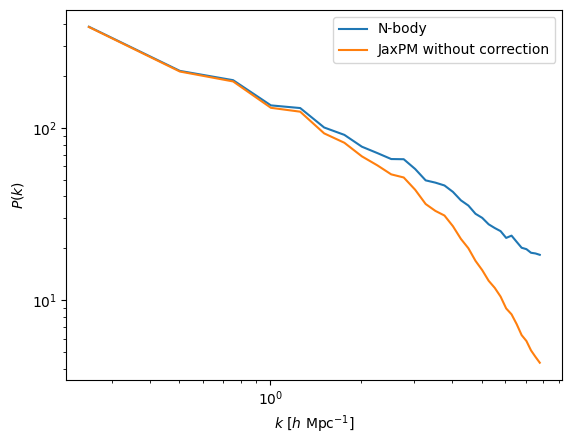

In [11]:
plt.loglog(k,pk_ref, label='N-body')
plt.loglog(k,pk_i, label='JaxPM without correction')
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

In [12]:
# Instantiate the neural network
model = hk.without_apply_rng(hk.transform(lambda x,a : NeuralSplineFourierFilter()(x,a)))

params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

In [13]:
kvec = fftk(mesh_shape)

In [14]:
kvec[0].shape

(64, 1, 1)

In [15]:
kvec[1].shape

(1, 64, 1)

In [16]:
kvec[2].shape

(1, 1, 33)

In [17]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * invlaplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = jnp.sqrt(sum((ki/jnp.pi)**2 for ki in kvec))
    # kk = jnp.sqrt(jnp.sum((ki/jnp.pi)**2 for ki in kvec))
    pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))
    
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [18]:
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0] - ref_pos)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  # Optional lines to include velocity in the loss
  vel = jnp.sum((res[1] - ref_vel)**2, axis=-1)
  wv = jnp.where(distance < 100, vel, 0.)
  return 0.01*jnp.mean(wv) + jnp.mean(w)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [19]:
losses = []

In [20]:
import optax
learning_rate=0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [21]:
for step in tqdm(range(100)):
  l, params, opt_state = update(params, opt_state)
  losses.append(l)

  0%|          | 0/100 [00:00<?, ?it/s]2024-11-11 16:02:12.450971: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %negate.330 = f32[34,262144,3]{2,1,0} negate(f32[34,262144,3]{2,1,0} %constant.874)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-11 16:02:34.984945: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 23.534050769s
Constant folding an instruction is taking > 1s:

  %negate.330 = f32[34,262144,3]{2,1,0} negate(f32[34,262144,3]{2,1,0} %constant.874)

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilat

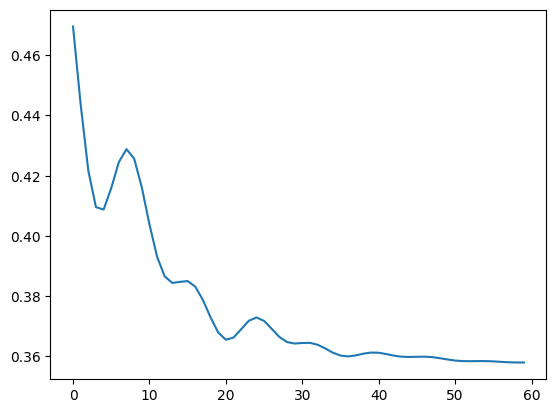

In [22]:
plt.plot(losses[40:])

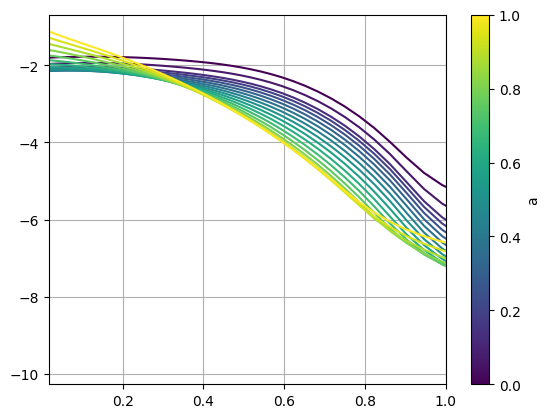

In [23]:
col = plt.cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

kvals = jnp.logspace(-2.,0,100)*np.sqrt(3)

fig, ax = plt.subplots()
for i, a in enumerate(scales[::2]): 
    ax.plot(kvals, model.apply(params, kvals , jnp.atleast_1d(a)), color=col[i])

sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('a')

ax.set(xlim=(kvals[0], 1))
ax.grid()

In [24]:
# col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

# kvals = jnp.logspace(-2.,0,100)*sqrt(3)

# for i, a in enumerate(scales[::2]): 
#     semilogx(kvals, model.apply(params, kvals , jnp.atleast_1d(a)), color=col[i])

# sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
# plt.colorbar(sm, label='a')

# xlim(kvals[0], sqrt(3))
# grid()

In [25]:
# col = cm.viridis(np.linspace(0.,1.0,len(scales[::2])))   

# kvals = jnp.logspace(-1.,0,100)*sqrt(3)

# for i, a in enumerate(scales[::2]): 
#     semilogx(kvals, model.apply(params, kvals , jnp.atleast_1d(a))/a, color=col[i])

# sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0., vmax=1))
# plt.colorbar(sm, label='a')
# xlim(kvals[0], sqrt(3))
# grid()

In [26]:
res = odeint(neural_nbody_ode, [poss[0], vels[0]], jnp.array(scales), cosmo, params, rtol=1e-5, atol=1e-5)

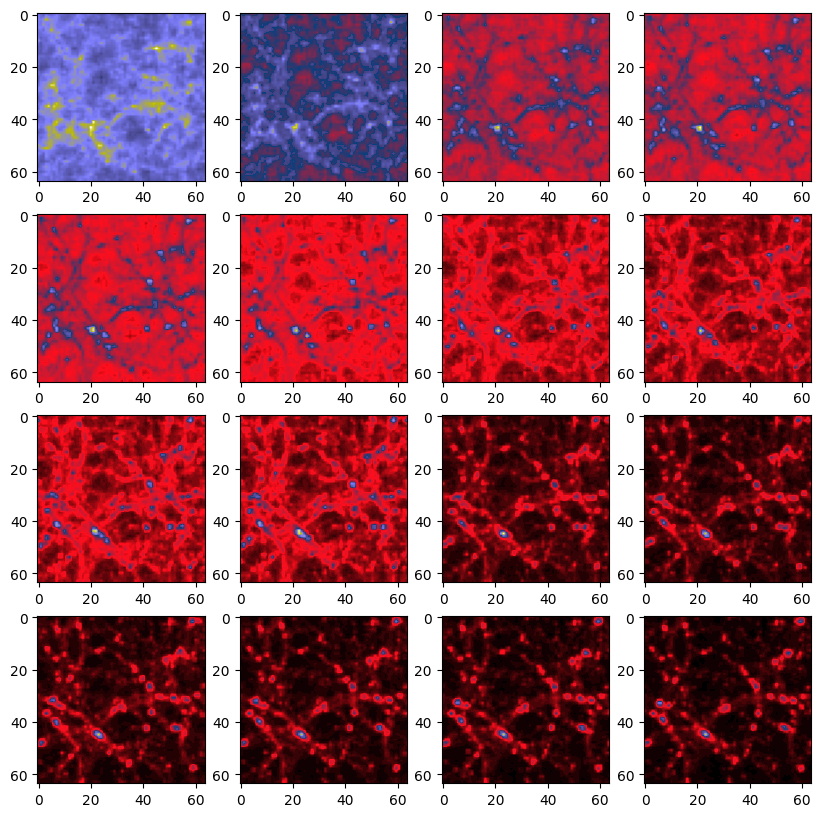

In [27]:
plt.figure(figsize=[10,10])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(cic_paint(jnp.zeros(mesh_shape), res[0][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [28]:
k, pk_ref = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), poss[-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_i = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), resi[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

k, pk_c = power_spectrum(
      (cic_paint(jnp.zeros(mesh_shape), res[0][-1])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

Text(0, 0.5, '$P(k)$')

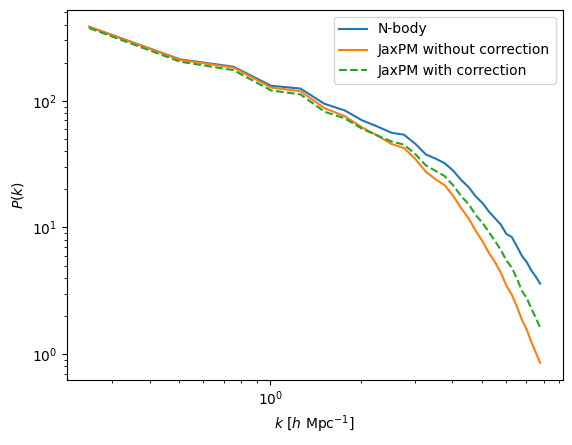

In [29]:
plt.loglog(k, pk_ref, label='N-body')
plt.loglog(k, pk_i, label='JaxPM without correction')
plt.loglog(k, pk_c, '--', label='JaxPM with correction')
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

(0.0, 1.5)

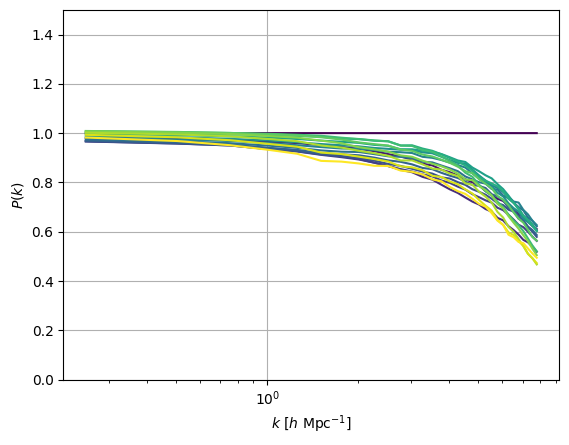

In [30]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_c = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), res[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    plt.semilogx(k, pk_c/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
# plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)

(0.0, 1.5)

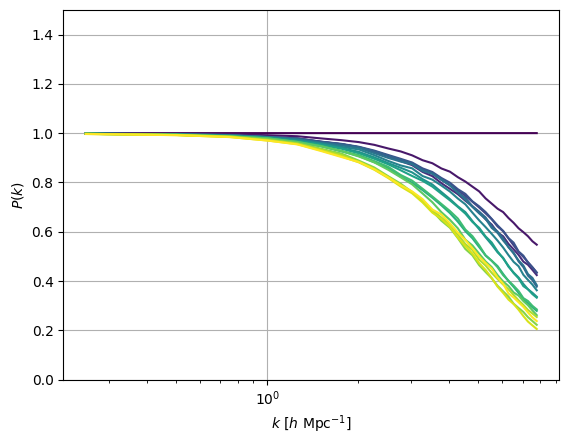

In [31]:
for i, a in enumerate(scales[::2]): 
    k, pk_ref = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), poss[::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    k, pk_i = power_spectrum(
          (cic_paint(jnp.zeros(mesh_shape), resi[0][::2][i])),
          boxsize=np.array([25.] * 3),
          kmin=np.pi / 25.,
          dk=2 * np.pi / 25.)

    plt.semilogx(k, pk_i/pk_ref, color=col[i])
    
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")
# plt.colorbar(sm, label='a')
plt.grid(True)
plt.ylim(0.,1.5)